In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoLarsCV
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.decomposition import PCA
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline

In [2]:
fires = utils.wrangle()

In [3]:
fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,6,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,3,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,7,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,1,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


## Least Squares Regression Analysis

This analysis suggests the data is mostly noise. The R^2 value implies that guessing the mean would be similarly effective in predicting the fire size. The P-values suggest that temperature, rain, and humidity values could be scramble within the data frame, and you would get similar results when fitting it again. 

In [4]:
# This regression analysis shows that we have some work in store for us.
# The connections between input variables and the target is extremely loose.

from statsmodels.formula.api import ols
fires['log'] = np.log(fires.area+1)
m = ols('log ~ temp + rain + RH + wind',fires).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                    log   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.345
Date:                Tue, 14 Mar 2017   Prob (F-statistic):              0.252
Time:                        17:18:00   Log-Likelihood:                -903.77
No. Observations:                 517   AIC:                             1818.
Df Residuals:                     512   BIC:                             1839.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.7420      0.443      1.674      0.0

# PCA

Principle component analysis in this setting allows us to visualize our high dimensional data on a plane and see whether any natural structure presents itself. 

Unfortunately the meteorological data does not break up the fires by size. FWIC metrics seem to add structure, but it is only through the relationships that they have to each other, and not to the target variable. 

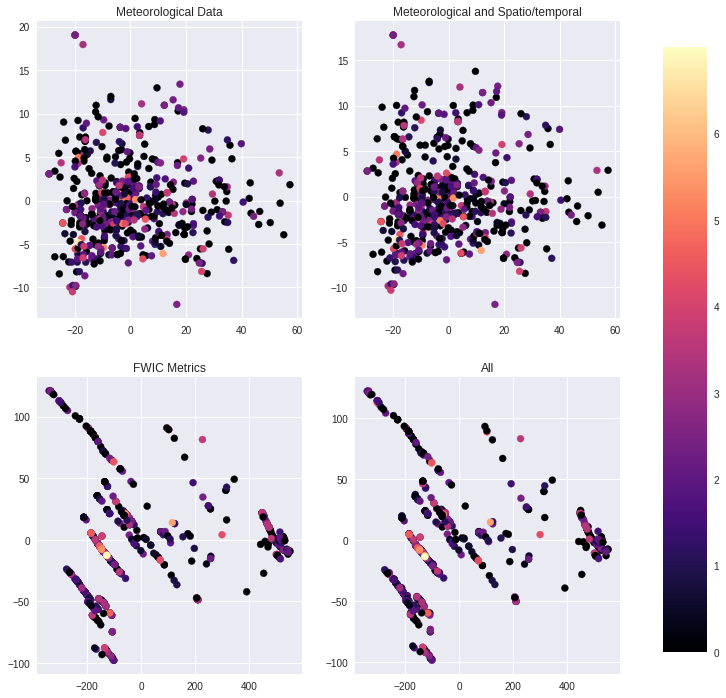

In [5]:
# Here we can see how fire size is distributed across the two dimensions of greatest 
# variation with different subsets of features. 

X1 = fires.ix[:,[8,9, 10, 11]]
X2 = fires.ix[:,[0,1,2,3, 8, 9, 10, 11]]
X3 = fires.ix[:,[4, 5, 6, 7]]
X4 = fires.ix[:,1:12]

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))

def pca_plot(data, ax):
    pca = PCA(n_components=2).fit_transform(data)
    return ax.scatter(pca[:,0], pca[:,1], c=fires.log, cmap=plt.cm.magma)

cax1 = pca_plot(X1, ax1)
cax2 = pca_plot(X2, ax2)
cax3 = pca_plot(X3, ax3)
cax4 = pca_plot(X4, ax4)

ax1.set_title("Meteorological Data")
ax2.set_title("Meteorological and Spatio/temporal")
ax3.set_title("FWIC Metrics")
ax4.set_title("All")

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(cax1, cax=cbar_ax)

f.subplots_adjust(hspace=.2)

plt.show()

# Features

Here we can determine which features to be included on all tests occurring below.

In [6]:
fires['sqrt_rain'] = np.sqrt(fires['rain'])

In [7]:
# Determine features
fires['sqrt_rain'] = np.sqrt(fires['rain'])

fires['sqrt_rain'] = fires
features = fires.ix[:,[8,9,10,11]]

#Scale input
X = scale(features)

#Take log of area and set y
y = np.log(fires.area.values+1).flatten()

In [8]:
# Unscale and evaluate MAE
def eval(y, y_):
    y1 = np.exp(y)-1
    y2 = np.exp(y_)-1
    score = np.mean(np.abs(y1-y2))
    return score

# Regression Techniques

Here I have created methods utilizing each of the regression algorithms that take in the data and spit out the mean standard error. The first three have built in cross-validation, while SVR does not. 

## Linear Regression

In [9]:
def LR(data):
    lr = LinearRegression()
    lr = lr.fit(data[0], data[2])
    y_ = lr.predict(data[1])
    return eval(y_, data[3])

## Ridge Regression

In [10]:
def RR(data):
    a = [1, 10, 100, 1000, 10000, 100000]
    ridge = RidgeCV(alphas=a)
    ridge = ridge.fit(data[0], data[2])
    y_ = ridge.predict(data[1])
    return eval(y_, data[3])

## ElasticNet 

In [11]:
def EN(data):
    l1s = [.0001,.001,.01,.1, .5, .7, .9, .95, .99, 1]
    a = [.1, 1, 10, 100, 1000]
    en = ElasticNetCV(l1_ratio=l1s, alphas=a)
    en = en.fit(data[0],data[2])
    y_ = en.predict(data[1])
    return eval(y_, data[3])

## Lasso Lars

In [12]:
def LL(data):
    ll = LassoLarsCV()
    l1 = ll.fit(data[0], data[2])
    y_ = ll.predict(data[1])
    return eval(y_, data[3])

## SVR

### Linear

In [13]:
def SVR_lin(data, param=None):
    # 5 fold CV
    if param==None:
        chosen_cs=[]
        for tr, te in KFold(n_splits=5,shuffle=True).split(data[0]):
            c_cv = [None, np.inf]
            #test all cs for specific fold
            for c in [0.1, 1, 1.5, 2, 2.5, 3, 3.5, 4, 10, 100]:
                svr = SVR(kernel='linear', C=c)
                svr = svr.fit(data[0][tr], data[2][tr])
                y_ = svr.predict(data[0][te])
                score = eval(y_, data[2][te])
                if score < c_cv[1]:
                    c_cv[1] = score
                    c_cv[0] = c
            chosen_cs.append(c_cv[0])
        
        best_c = np.mean(chosen_cs)
    else:
        best_c = param[0]
    
    #run linear SVR with best c
    svr = SVR(kernel='linear', C=best_c, epsilon=param[1])
    svr = svr.fit(data[0], data[2])
    y_ = svr.predict(data[1])
    return eval(y_, data[3])

### Rbf

In [14]:
def SVR_rbf(data, param=None):
    # 5 fold CV
    if param==None:
        chosen_cs=[]
        chosen_es=[]
        for tr, te in KFold(n_splits=5,shuffle=True).split(data[0]):
            c_cv = [None, np.inf, None]
            #test all cs for specific fold
            for c in [0.1, 1, 1.5, 2, 2.5, 3, 3.5, 4, 10, 100]:
                e_cv=[None, np.inf]
                for e in [0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4]:
                    svr = SVR(kernel='rbf', C=c, epsilon=e, gamma=0.075)
                    svr = svr.fit(data[0][tr], data[2][tr])
                    y_ = svr.predict(data[0][te])
                    score = eval(y_, data[2][te])
                    if score < e_cv[1]:
                        e_cv[1] = score
                        e_cv[0] = e
                if e_cv[1] < c_cv[1]:
                    c_cv[1] = e_cv[1]
                    c_cv[0] = c
                    c_cv[2] = e_cv[0]
            chosen_cs.append(c_cv[0])
            chosen_es.append(c_cv[2])
        
        best_c = np.mean(chosen_cs)
        best_e = np.mean(chosen_es)
    else:
        best_c = param[0]
        best_e = param[1]
        
    #run linear SVR with best c
    svr = SVR(kernel='rbf', C=best_c, epsilon=best_e, gamma=param[2])
    svr = svr.fit(data[0], data[2])
    y_ = svr.predict(data[1])
    return eval(y_, data[3])

## Gradient Boosting Regressor

In [15]:
def GBR(data):
    adr = GradientBoostingRegressor(loss='lad', criterion='mae', max_depth=1)
    adr = adr.fit(data[0], data[2])
    y_ = adr.predict(data[1])
    return eval(y_, data[3])

## Hybrid - SVR and GBR

In [16]:
def hybrid(data):
    svr = SVR(kernel='rbf', C=3, epsilon=0.31, gamma=0.075)
    svr = svr.fit(data[0], data[2])
    y1_ = svr.predict(data[1])
    adr = GradientBoostingRegressor(loss='lad', criterion='mae', max_depth=1)
    adr = adr.fit(data[0], data[2])
    y2_ = adr.predict(data[1])
    y_ = (y1_ + y2_)/2
    return eval(y_, data[3]), y_

# Results of 30 trials

In [57]:
# **WARNING Takes a few minutes to process**
#Because this takes a while to run, here are the most recent results:
#
#MAE from the mean fire size: 18.566830958252577

results = {
    'Linear Regression':[],
    'Ridge Regression':[],
    'Elastic Net':[],
    'Lasso Lars':[],
    'SVR Linear':[],
    'SVR Rbf':[],
    'GBR':[],
    'Hybrid':[]
}

for i in range(30):
    
    kf = KFold(n_splits=10, shuffle=True)
    for tr, te in kf.split(X):
        data = (X[tr], X[te], y[tr].flatten(), y[te])
        results['Linear Regression'].append(LR(data))
        results['Ridge Regression'].append(RR(data))
        results['Elastic Net'].append(EN(data))
        results["Lasso Lars"].append(LL(data))
        results['SVR Linear'].append(SVR_lin(data, (3,0.31)))
        results["GBR"].append(GBR(data))
        results['SVR Rbf'].append(SVR_rbf(data, (3,0.31, 0.075)))
        results['Hybrid'].append(hybrid(data)[0])
        
            
for key, value in results.items():
    print(key, ": ", np.mean(value))

Linear Regression :  13.0137508523
Ridge Regression :  12.9993579524
Elastic Net :  12.9903695868
Lasso Lars :  12.9903695868
SVR Linear :  12.8545782147
SVR Rbf :  12.6979199214
GBR :  12.7082905185
Hybrid :  12.6883955539


In [17]:
# **WARNING takes a few minutes to process**

prediction = np.array([])
actual = np.array([])

for i in range(30):
    kf = KFold(n_splits=10, shuffle=True)
    for tr, te in kf.split(X):
        data = (X[tr], X[te], y[tr].flatten(), y[te])
        y_ = hybrid(data)[1]
        prediction = np.concatenate((prediction, y_))
        actual = np.concatenate((actual, te))

This graph comparing predictions and actual sizes is telling. Many of the predictions seem to just be a guess in the 0-5 region, while predictions venture into the +5 region when the fires actually are larger than 5. A prediction of less than 5 may not be very meaningful, but a prediction of greater than 10 is highly indicative of a fire greater than 5.  

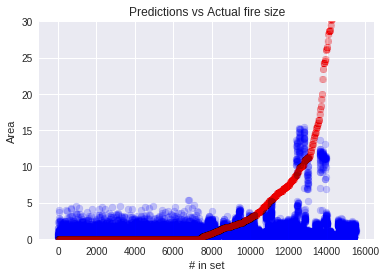

In [18]:
# Comparing predictions with actual fire size

Results = pd.DataFrame()
actual = actual.astype(np.int)
Results['y'] = fires.area.values[actual]
Results['hat'] = np.exp(prediction) - 1
Results['abs_err'] = np.abs(Results.y-Results.hat)

test_grid = np.transpose([range(len(Results)), np.sort(Results.y.values)])
pred_grid = np.transpose([range(len(Results)), Results.sort_values('y').hat.values])

plt.scatter(pred_grid[:,0], pred_grid[:,1], c='b', alpha=0.2)
plt.scatter(test_grid[:,0], test_grid[:,1], c='r',alpha=0.01)
plt.ylim((0,30))
plt.title("Predictions vs Actual fire size")
plt.ylabel('Area')
plt.xlabel('# in set')
plt.show()

The regression error characteristic curve suggests that the model contains many predictions within a quite reasonable error threshold. For example, 60% of the predictions are within 2 hecatres of error.  However, the tail suggests an extreme degree error for 10% or more of the test predictions.

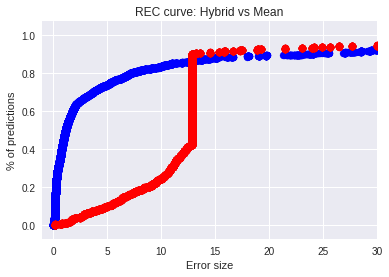

In [19]:
# REC curve of the ensemble method vs guessing the mean fire size. 

rec = np.transpose([np.sort(Results['abs_err'].values), 
        np.array(range(len(Results)))/len(Results)])

diff = np.abs(Results.y-np.mean(Results.y))

rec_mean = np.transpose([np.sort(diff),
        np.array(range(len(Results)))/len(Results) ])

plt.scatter(rec[:,0], rec[:,1], c='b')
plt.scatter(rec_mean[:,0], rec_mean[:,1], c='r')
plt.xlim((-1,30))
plt.title('REC curve: Hybrid vs Mean')
plt.xlabel('Error size')
plt.ylabel('% of predictions')
plt.show()